# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


## Import Libraries 

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Explore Data

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


For the dataset 'profil' I want to drop all the blank profiles, which have no values in gender, age and income.

In [4]:
blank_profile = profile[(profile.gender.isnull()) & (profile.age == 118) & (profile.income.isnull())]
profile = profile[~profile.isin(blank_profile)].dropna()

Here the distribution of the 'age' and 'income' data.

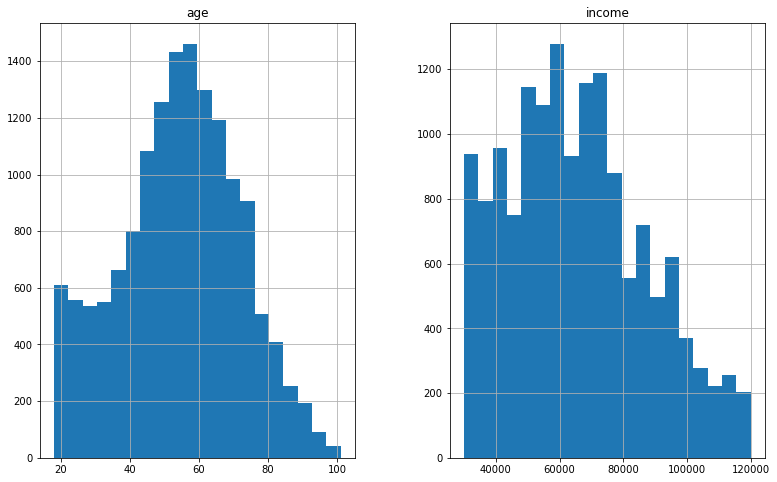

In [5]:
profile[['age', 'income']].hist(bins=20,figsize=(13, 8))
plt.show()

In [6]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


##  Cleaning the data sets

### Encoding the user IDs and the offer IDs 

Using the email_mapper from a previous project we are gonna encode the user ID and later the offer ID

In [7]:
def id_mapper(_list_):
    '''
    INPUT:
    _list_ - (list) a list 
    
    OUTPUT:
    id_encoded - (list) an encoded version of the _list_
    '''
    coded_dict = dict()
    cter = 1
    id_encoded = []
    
    for val in _list_:
        if val not in coded_dict:    #to ensure each ID will only be encoded once
            coded_dict[val] = cter
            cter+=1
        
        id_encoded.append(coded_dict[val])
    return id_encoded

In [8]:
#get the same user_id for profile and transcript
user_list = profile['id'].tolist()
user_list2 = transcript['person'].tolist()

joined_list = user_list + user_list2 

id_encoded = id_mapper(joined_list)

profile_list = id_encoded[:len(user_list)]
transcript_list = id_encoded[len(user_list):len(joined_list)]

del profile['id']
profile['user_id'] = profile_list

del transcript['person']
transcript['user_id'] = transcript_list

In [9]:
#get the encoded offer ID
offer_id = portfolio['id'].tolist()

id_encoded = id_mapper(offer_id)
portfolio_list = id_encoded
del portfolio['id']
portfolio['offer_id'] = portfolio_list

To encode the offer ID in "transcription" we need to slice the string containing the ID<br>
Example<br>
Input:   {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}<br>
Output:  4

In [10]:
subset_trans = transcript
subset_trans['value'] = subset_trans['value'].astype('str')

subset_trans.loc[subset_trans['event'] == 'offer received', 'offer_id'] = subset_trans['value'].str.slice(14,-2)
subset_trans.loc[subset_trans['event'] == 'offer viewed', 'offer_id'] = subset_trans['value'].str.slice(14,-2)
subset_trans.loc[subset_trans['event'] == 'offer completed', 'offer_id'] = subset_trans['value'].str.slice(14,-15)
subset_trans.loc[subset_trans['event'] == 'transaction', 'Transaction'] = subset_trans['value'].str.slice(10,-1)

for index in range(len(offer_id)):
    
    subset_trans.loc[subset_trans['offer_id'] == offer_id[index], 'Offer_ID'] = id_encoded[index]
    subset_trans.loc[subset_trans['offer_id'].str.slice(0,-1) == offer_id[index], 'Offer_ID'] = id_encoded[index]

#Dropping unnecessary columns
subset_trans = subset_trans.drop(['value'], axis = 1)
subset_trans = subset_trans.drop(['offer_id'], axis = 1)

#Fill the NaN's by 0
subset_trans['Transaction'] = subset_trans['Transaction'].fillna(0)
subset_trans['Offer_ID'] = subset_trans['Offer_ID'].fillna(0)

Example for User ID 4 of the former "transcript" - df

In [11]:
user_4 = subset_trans[subset_trans['user_id'] == 4]
user_4.head()

,event,time,user_id,Transaction,Offer_ID
5,offer received,0,4,0,9.0
12650,offer viewed,0,4,0,9.0
32625,transaction,60,4,9.54,0.0
32626,offer completed,60,4,0,9.0
53179,offer received,168,4,0,4.0


### Creating a binary matrix

In [12]:
#Creating a binary matrix for the offers
dummies = pd.DataFrame(pd.get_dummies(subset_trans['event']))

In [13]:
#Combining the subset_trans and the binary matrix of the offers and reorganising the df
new_transcript = pd.concat([subset_trans, dummies], axis=1)
new_transcript = new_transcript.drop(['transaction'], axis = 1)
new_transcript = new_transcript.drop(['event'], axis = 1)
new_transcript = new_transcript[['time','user_id','Offer_ID','offer received', 'offer viewed', 'offer completed','Transaction']]

new_transcript.head()

,time,user_id,Offer_ID,offer received,offer viewed,offer completed,Transaction
0,0,2,4.0,1,0,0,0
1,0,14826,5.0,1,0,0,0
2,0,3,10.0,1,0,0,0
3,0,14827,7.0,1,0,0,0
4,0,14828,2.0,1,0,0,0


In [14]:
def summarize_offer(offer_id):
    '''
    INPUT:
    offer_id - int
    
    OUTPUT:
    new_df - dataframe with all interactions of the offer_id
    
    '''
    new_df = new_transcript[new_transcript['Offer_ID']==offer_id]
    new_df = new_df.groupby(['user_id','Offer_ID']).sum()
    return new_df

In [15]:
#getting a df to start the summarize with
id_one_df = summarize_offer(1)

In [16]:
id_list = portfolio.offer_id.tolist() #getting the offer Id's

#summarizing for all offer Id's
for ids in id_list[1:]:
    new_df = summarize_offer(ids)
    id_one_df = pd.concat([id_one_df, new_df])

In [17]:
#renaming the df adn dropping the time
Offer_df = id_one_df
Offer_df = Offer_df.reset_index()
Offer_df = Offer_df.drop(['time'], axis = 1)
Offer_df

,user_id,Offer_ID,offer received,offer viewed,offer completed
0,2,1.0,1,1,1
1,6,1.0,1,1,1
2,7,1.0,1,1,0
3,9,1.0,1,1,1
4,11,1.0,1,1,0
...,...,...,...,...,...
63283,16981,10.0,2,2,0
63284,16985,10.0,2,2,0
63285,16993,10.0,2,1,0
63286,16995,10.0,1,0,0


## Finding relevant users

Since there are some demographic groups who will make a purchase without seeing the offer first, we will 
make a group which has seen the offer and one who hasn't.

In [18]:
#Show Users who didn't complete the offer or completed the offer without seeing it first
no_views = Offer_df[(Offer_df['offer completed'] == 0) | (Offer_df['offer viewed'] == 0)]

In [19]:
#Remove rows which are in no_views to get the relevant users
Relevant_Offer = Offer_df[~Offer_df.isin(no_views)].dropna()
Relevant_Offer

,user_id,Offer_ID,offer received,offer viewed,offer completed
0,2.0,1.0,1.0,1.0,1.0
1,6.0,1.0,1.0,1.0,1.0
3,9.0,1.0,1.0,1.0,1.0
5,13.0,1.0,2.0,2.0,1.0
9,25.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...
63261,16904.0,10.0,1.0,1.0,1.0
63262,16906.0,10.0,1.0,1.0,1.0
63267,16920.0,10.0,2.0,1.0,1.0
63276,16949.0,10.0,1.0,1.0,1.0


In the dataframe Offer_df are now all the user who have at least seen one offer and completed at least one offer.
That means that there are still User who have completed more offers than they have seen.
At this point I would have asked the marketing department, whether those are still relevant users.
Since this is just an example I will define those users as relevant users, since they worked at least once with a offer.

In [20]:
#For the later prediction we add a column which showas a relevant user with a '1' and an inrelevant user with a '0'

pd.options.mode.chained_assignment = None  # default='warn'
no_views['Relevant_Offer'] = 0
Relevant_Offer['Relevant_Offer'] = 1

In [21]:
frames = [Relevant_Offer, no_views]

Relevance_df = pd.concat(frames)
Relevance_df = Relevance_df.reset_index()
Relevance_df = Relevance_df.drop(['offer received', 'offer viewed', 'offer completed', 'index'], axis=1)

Relevance_df

,user_id,Offer_ID,Relevant_Offer
0,2.0,1.0,1
1,6.0,1.0,1
2,9.0,1.0,1
3,13.0,1.0,1
4,25.0,1.0,1
...,...,...,...
63283,16981.0,10.0,0
63284,16985.0,10.0,0
63285,16993.0,10.0,0
63286,16995.0,10.0,0


In [22]:
#change the type of 'became_member_on' from int into datettime and drop the former column
profile['Became_Member_On'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile = profile.drop(['became_member_on'], axis=1)
profile.head()

,gender,age,income,user_id,Became_Member_On
1,F,55.0,112000.0,1,2017-07-15
3,F,75.0,100000.0,2,2017-05-09
5,M,68.0,70000.0,3,2018-04-26
8,M,65.0,53000.0,4,2018-02-09
12,M,58.0,51000.0,5,2017-11-11


In [23]:
#get the years of membership since the joining
profile['Member_for_x_years'] = pd.to_datetime("today") - profile.Became_Member_On
profile['Member_for_x_years'] = round(profile.Member_for_x_years / np.timedelta64(1,'Y'),2)

## Prediction whether a user will respond to a offer

For the prediction model we have to turn all columns into numerical types.

In [24]:
final_df = pd.merge(profile, Relevance_df, on='user_id')
final_df = final_df.drop(['Became_Member_On'], axis=1)
final_df

,gender,age,income,user_id,Member_for_x_years,Offer_ID,Relevant_Offer
0,F,55.0,112000.0,1,4.87,3.0,0
1,F,55.0,112000.0,1,4.87,4.0,0
2,F,75.0,100000.0,2,5.05,1.0,1
3,F,75.0,100000.0,2,5.05,4.0,1
4,F,75.0,100000.0,2,5.05,9.0,1
...,...,...,...,...,...,...,...
55217,F,83.0,50000.0,14824,6.22,2.0,1
55218,F,83.0,50000.0,14824,6.22,4.0,1
55219,F,62.0,82000.0,14825,4.85,6.0,1
55220,F,62.0,82000.0,14825,4.85,9.0,1


In [25]:
final_df['gender'] = final_df['gender'].replace({'F': 1, 'M': 2, 'O': 3}) #replcace 'F','M' and 'O' with 1,2 and 3

In [27]:
#declaring the Output and Input variables
y = final_df['Relevant_Offer'] #Output
X = final_df.drop(['Relevant_Offer', 'user_id'], axis=1) #Input

In [28]:
#Here we split the data into a test and into a training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)

To get a good accuracy, I am trying 5 classifier.

In [39]:
clf_tree = DecisionTreeClassifier(random_state=21, max_depth = 7, max_leaf_nodes=6).fit(X_train,y_train)
clf_kneigh = KNeighborsClassifier(3).fit(X_train,y_train)
clf_gaus = GaussianNB().fit(X_train,y_train)
clf_forest = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1).fit(X_train,y_train)
clf_ada = AdaBoostClassifier().fit(X_train,y_train)

In [40]:
y_pred_tree = clf_tree.predict(X_test)
y_pred_kneigh = clf_kneigh.predict(X_test)
y_pred_gaus = clf_gaus.predict(X_test)
y_pred_forest = clf_forest.predict(X_test)
y_pred_ada = clf_ada.predict(X_test)
print("DecisionTree:", accuracy_score(y_test,y_pred_tree))
print("Kneighbors:", accuracy_score(y_test,y_pred_kneigh))
print("GaussianNB:", accuracy_score(y_test,y_pred_gaus))
print("RandomForest:", accuracy_score(y_test,y_pred_forest))
print("AdaBoost:", accuracy_score(y_test,y_pred_ada))

DecisionTree: 0.7233087063595538
Kneighbors: 0.6114732724902217
GaussianNB: 0.6016224829784151
RandomForest: 0.6841952774156164
AdaBoost: 0.750615674344488


With the AdaBoostClassifier we get an Accuracy of 75 % to predict whether a person will respond to an offer or not.<br>
An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional<br> copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that <br>subsequent classifiers focus more on difficult cases. [AdaBoostClassifier](https://scikit-learn.org/0.15/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier)

In [42]:
print("Precision:", precision_score(y_test,y_pred_ada,pos_label=0))
print("Recall:", recall_score(y_test,y_pred_ada,pos_label=0))
print("F Score:", f1_score(y_test,y_pred_ada,pos_label=0))
print("Confusion Matrix:\n", confusion_matrix(y_test,y_pred_ada))

Precision: 0.7873430694337689
Recall: 0.7751292722915878
F Score: 0.7811884334286622
Confusion Matrix:
 [[6146 1783]
 [1660 4217]]


As a next step we could predict which offer will be most likely be responded to by a certain user.<br>
Here an example:

In [45]:
#one example
gender = 2
age = 50
income = 112000
member_for = 5
send_offer_for = []
for ids in id_list[1:]:

    Xnew = [[gender, age, income, member_for, ids]]
    # make a prediction
    ynew = clf_ada.predict(Xnew)
    if ynew == 1:
        send_offer_for.append(ids)

print('Send User the following offers:',send_offer_for)

Send User the following offers: [2, 4, 5, 6, 7, 9, 10]


Here we predicte a respond of the user for the Offer 2, 4, 5, 6, 7, 9 and 10.